Hunter Bennett | Glass Lab | June 03 2021  
Kupffer cell strains project  
  

Preliminary goal here is to start to understand the epigenetic F1 data so we can start to analyze it and incorporate into our paper. In this case we will look at the F1 H3K27Ac ChIP-seq data.

# Import packages

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 500

# clustering packages
import scipy
import scipy.cluster.hierarchy as sch
import scipy.spatial.distance as dist

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

### Set Matplotlib Plotting Parameters

In [3]:
# #### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # # get matplotlib to save readable fonts
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['font.size'] = 8

# # line widths
# matplotlib.rcParams['axes.linewidth'] = 1
# matplotlib.rcParams['xtick.major.width'] = 1
# matplotlib.rcParams['ytick.major.width'] = 1

# # adjust defualt color for plots to black
# # normal default is a dark gray
# COLOR = 'black'
# matplotlib.rcParams['text.color'] = COLOR
# matplotlib.rcParams['axes.labelcolor'] = COLOR
# matplotlib.rcParams['xtick.color'] = COLOR
# matplotlib.rcParams['ytick.color'] = COLOR
# matplotlib.rcParams['axes.edgecolor'] = COLOR

# #### PLOT PARAMETERS FOR THIS PLOT ####

### Set working directory

In [4]:
dataDirectory = '/home/h1bennet/strains/data/ATAC/control_f1/'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control_ATAC/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


Lets start by taking a look at the data on the browser in an organized way.

    makeMultiWigHub.pl hrb_strains_f1_atac_perfect mm10 \
    -color 49,163,84 49,163,84 49,163,84 49,163,84 \
    49,130,189 49,130,189 49,130,189 49,130,189 \
    -force -d \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.mm10.bowtie2.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.mm10.bowtie2.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.mm10.bowtie2.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.mm10.bowtie2.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
    /home/h1bennet/strains/data/ATAC/control_f1/tag_perfect_reads_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam
   

    makeMultiWigHub.pl hrb_strains_f1_atac_onlymuts mm10 \
        -color 49,163,84 49,163,84 49,163,84 49,163,84 \
        49,130,189 49,130,189 49,130,189 49,130,189 \
        -force -d \
         /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.mm10.bowtie2.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.mm10.bowtie2.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.mm10.bowtie2.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.mm10.bowtie2.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61A_TDT_l20210213_CTAGTACG_TCGACTAG_S7_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61B_TDT_l20210213_TTCTGCCT_TTCTAGCT_S8_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61C_TDT_l20210213_GCTCAGGA_CCTAGAGT_S9_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam \
        /home/h1bennet/strains/data/ATAC/control_f1/tag_only_muts_mouse_cb6f1j_Male_Kupffer_ATAC_Chow_healthyoung_CB61D_TDT_l20210213_AGGAGTCC_GCGTAAGA_S10_L001_trim30.balbcj.bowtie2_shifted_from_BALBCJ.sam

In [9]:
perfect_c57bl6j_control_paths = list(np.sort(glob.glob(dataDirectory+'/tag_perfect*mm10*')))
perfect_balbcj_control_paths = list(np.sort(glob.glob(dataDirectory+'/tag_perfect*balbcj*')))
onlymuts_c57bl6j_paths = list(np.sort(glob.glob(dataDirectory+'/tag_only_muts*mm10*')))
onlymuts_balbcj_paths = list(np.sort(glob.glob(dataDirectory+'/tag_only_muts*balbcj*')))

perfect_c57bl6j_control_ids = [i.split('/')[-1].split('_')[10] for i in perfect_c57bl6j_control_paths]
perfect_balbcj_control_ids = [i.split('/')[-1].split('_')[10] for i in perfect_balbcj_control_paths]
onlymuts_c57bl6j_ids = [i.split('/')[-1].split('_')[10] for i in onlymuts_c57bl6j_paths]
onlymuts_balbcj_ids = [i.split('/')[-1].split('_')[10] for i in onlymuts_balbcj_paths]

In [10]:
ids = ['perfect_c57bl6j_control_paths',
       'perfect_balbcj_control_paths',
       'onlymuts_c57bl6j_paths',
       'onlymuts_balbcj_paths'
      ]

colors = ['#31a354',
          '#3182bd',
          '#006d2c',
          '#08519c'
         ]

paths = [';'.join(perfect_c57bl6j_control_paths),
         ';'.join(perfect_balbcj_control_paths),
         ';'.join(onlymuts_c57bl6j_paths),
         ';'.join(onlymuts_balbcj_paths)
        ]

short_ids = [';'.join(perfect_c57bl6j_control_ids),
             ';'.join(perfect_balbcj_control_ids),
             ';'.join(onlymuts_c57bl6j_ids),
             ';'.join(onlymuts_balbcj_ids)
            ]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDef.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

In [11]:
pd.DataFrame([ids,colors,paths,short_ids]).T

,0,1,2,3
0,perfect_c57bl6j_control_paths,#31a354,/home/h1bennet/strains/data/ATAC/control_f1/ta...,CB61A;CB61B;CB61C;CB61D
1,perfect_balbcj_control_paths,#3182bd,/home/h1bennet/strains/data/ATAC/control_f1/ta...,CB61A;CB61B;CB61C;CB61D
2,onlymuts_c57bl6j_paths,#006d2c,/home/h1bennet/strains/data/ATAC/control_f1/ta...,CB61A;CB61B;CB61C;CB61D
3,onlymuts_balbcj_paths,#08519c,/home/h1bennet/strains/data/ATAC/control_f1/ta...,CB61A;CB61B;CB61C;CB61D


    source activate r-ouyangPipe

    alignStats.R ./sampleDef.txt > qcStats.txt

# plot QC info

In [12]:
qc = pd.read_csv('./qcStats.txt', sep='\t', index_col=0)
qc.index.rename('sample', inplace=True)
qc = qc.reset_index()

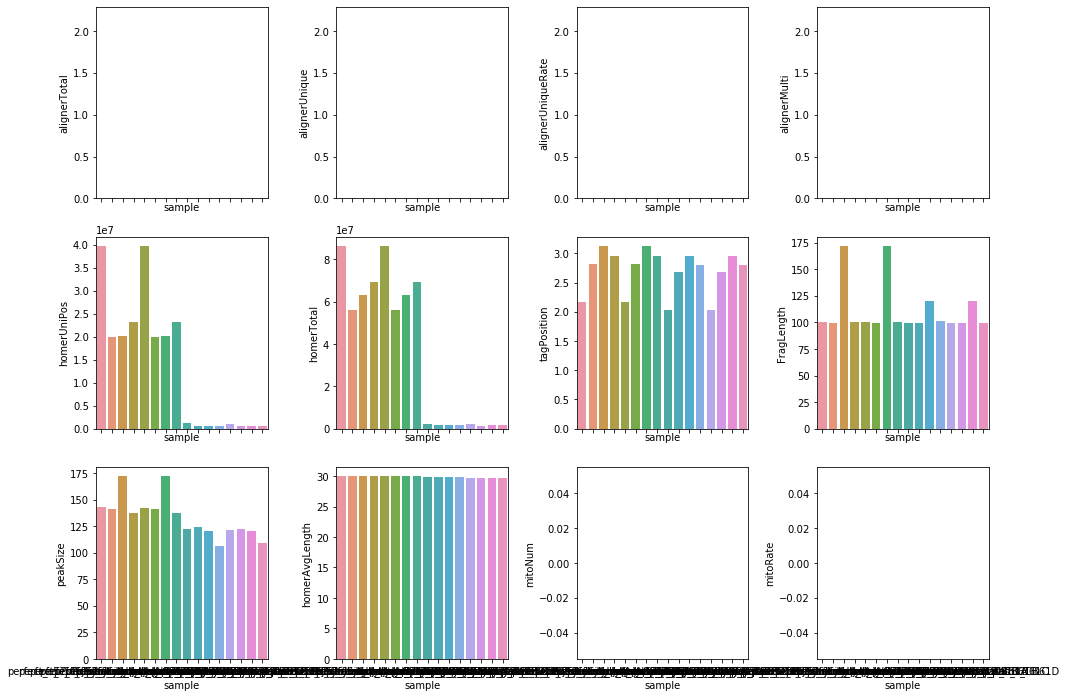

In [13]:
fig, axs = plt.subplots(3, 4, figsize=(16, 12), sharex=True)
plt.subplots_adjust(wspace=0.4)

for col, ax in zip(qc.columns[1:], axs.flat):
    sns.barplot(x='sample', y=col, data=qc, ax=ax)